In [3]:
import os, glob, time, re, json
import cv2
import matplotlib.pyplot as plt
import moviepy.editor as mp
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip

class PreprocessPretext:
    """
    videoPathL = sorted(glob.glob("/home/jovyan/data-vol-2/HAR/C10/20220805/*.mp4"))[:5]
    obj = PreprocessPretext( videoPathL, "../_data/pretext/v20" )
    #obj.getOverallInfo(rotateL=None)
    obj.clip()
    obj.check()
    obj.generate_csv()
    obj.updateRecord()
    """
    def __init__(self, videoPathL, outputPath, recordPretextPath="./recordPretext.json", videoLength=2.4, logPretextPath="./logPretext.txt"):
        self.videoPathL = videoPathL
        self.outputPath = outputPath
        self.recordPretextPath = recordPretextPath
        self.videoLength = videoLength
        self.logPath = logPretextPath
        self.getOverallInfo()
    
    def getOverallInfo(self, rotateL=None):
        path = os.path.dirname(self.videoPathL[0])
        wantProcessedS = set(map(lambda path:path.split("/")[-1], self.videoPathL))
        hasProcessedS  = json.load(open(self.recordPretextPath,"r")).keys() if glob.glob(self.recordPretextPath) else set()
        needProcessedS = wantProcessedS - hasProcessedS
        print(f"len(hasProcessedS)={len(hasProcessedS)}")
        print(f"len(needProcessedS)={len(needProcessedS)}")
        self.videoPathL = sorted(list(filter(lambda path:path.split('/')[-1] in needProcessedS, self.videoPathL)))
        self.rotateL = rotateL if rotateL else [0]*len(needProcessedS)
        for i,videoPath in enumerate(self.videoPathL):
            frames, fps, height, width = self.getVideoInfo(videoPath)
            print(f"{i}, {videoPath.split('/')[-1]}, frames={frames}, fps={fps}, height={height}, width={width}")
            #self.show1Frame(videoPath, self.rotateL[i])
    
    def getVideoInfo(self, videoPath):
        cap    = cv2.VideoCapture(videoPath)
        frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
        fps    = cap.get(cv2.CAP_PROP_FPS)
        height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
        width  = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
        cap.release()
        return int(frames), round(fps), int(height), int(width)
    
    def show1Frame(self, videoPath, rotate=0): # rotate: 1 right-90, 2 left-90, 5 vflip
        cap = cv2.VideoCapture(videoPath)
        success, img = cap.read()
        if success:
            if rotate==1:
                img = cv2.rotate(img,cv2.ROTATE_90_CLOCKWISE)
            elif rotate==2:
                img = cv2.rotate(img,cv2.ROTATE_90_COUNTERCLOCKWISE)
            elif rotate==5:
                img = cv2.rotate(img,cv2.ROTATE_180)
            plt.imshow(img[:,:,::-1])
            plt.show()
        cap.release()
        
    def clip(self):
        os.makedirs(self.outputPath, exist_ok=True)
        os.makedirs(f"{self.outputPath}/videos", exist_ok=True)
        for i,videoPath in enumerate(self.videoPathL):
            print(f"\r{i+1}/{len(self.videoPathL)}", end="")
            #
            clip = mp.VideoFileClip(videoPath)
            if self.rotateL[i]==1: # right90
                clip = clip.rotate(270)
            elif self.rotateL[i]==2: # left 90
                clip = clip.rotate(90)
            elif self.rotateL[i]==5: # vflip
                clip = clip.rotate(180)
            clip = clip.resize( (568,320) ) # modify aspect ratio (w,h)
            #
            frames, fps, _, _ = self.getVideoInfo(videoPath)
            subN =  int(frames/fps/self.videoLength)-1
            for j in range(subN):
                videoName = videoPath.replace('.mp4','_'+str(j)+'.mp4').split('/')[-1]
                if glob.glob(f"{self.outputPath}/{videoName}"):
                    continue
                try:
                    subclip = clip.subclip(j*self.videoLength,(j+1)*self.videoLength)
                    subclip.write_videofile(f"{self.outputPath}/videos/{videoName}", verbose=False, logger=None)
                except Exception as e:
                    with open(self.logPath,"a") as f:
                        f.write(str(e)+"\n")
        print()
            
    def check(self):
        for i,videoPath in enumerate(sorted(glob.glob(f"{self.outputPath}/videos/*.mp4"))):
            print(f"\r{i}", end="")
            cap = cv2.VideoCapture(videoPath)
            success, img = cap.read()
            assert bool(success), videoPath
            frames, fps, height, width = self.getVideoInfo(videoPath)
            assert abs(frames-1)<=fps*self.videoLength, (frames,videoPath)
            cap.release()
        print("\ncheck video and frames complete")
    
    def generate_csv(self):
        with open(f"{self.outputPath}/all.csv","w") as f:
            for videoPath in sorted(glob.glob(f"{self.outputPath}/videos/*.mp4")):
                f.write(f"{os.path.abspath(videoPath)} 0\n")
        for name in ["train","val","test"]:
            os.system(f"cp {self.outputPath}/all.csv {self.outputPath}/{name}.csv")
            
    def updateRecord(self):
        oriD = json.load(open(self.recordPretextPath,"r")) if glob.glob(self.recordPretextPath) else {}
        newD = { videoName:rotate for videoName,rotate in zip(map(lambda p:p.split('/')[-1],self.videoPathL),self.rotateL) }
        print(f"oriD={oriD}")
        print(f"newD={newD}")
        json.dump({**oriD,**newD},open(self.recordPretextPath,"w"))

len(hasProcessedS)=0
len(needProcessedS)=10
0, video_20220810080429.mp4, frames=8921, fps=30, height=1080, width=1920


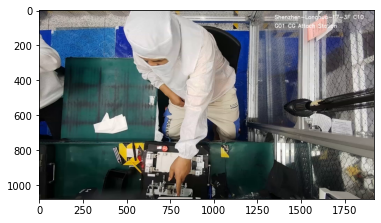

1, video_20220810080929.mp4, frames=8921, fps=30, height=1080, width=1920


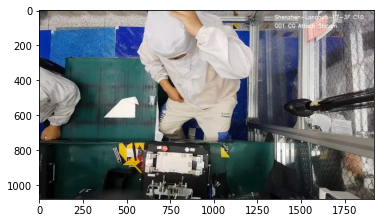

2, video_20220810081429.mp4, frames=8929, fps=30, height=1080, width=1920


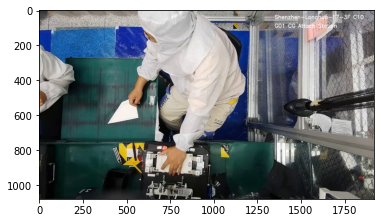

3, video_20220810081929.mp4, frames=8925, fps=30, height=1080, width=1920


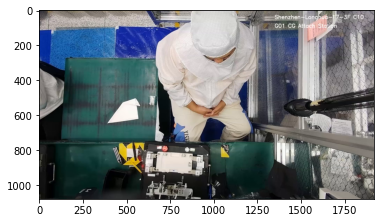

4, video_20220810082429.mp4, frames=8937, fps=30, height=1080, width=1920


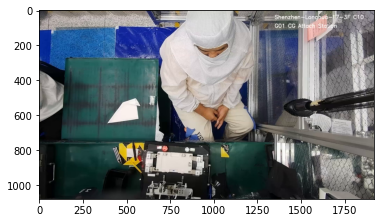

5, video_20220810082929.mp4, frames=8927, fps=30, height=1080, width=1920


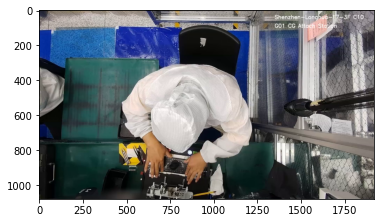

6, video_20220810083429.mp4, frames=8908, fps=30, height=1080, width=1920


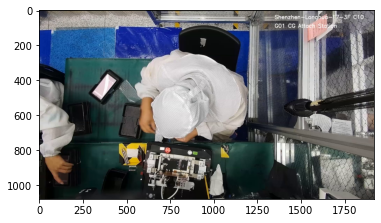

7, video_20220810083930.mp4, frames=8914, fps=30, height=1080, width=1920


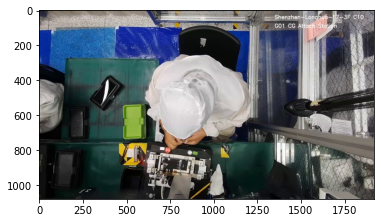

8, video_20220810084430.mp4, frames=8930, fps=30, height=1080, width=1920


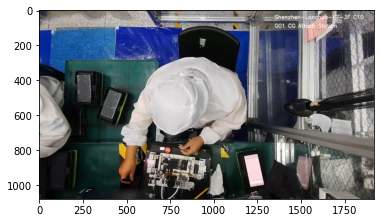

9, video_20220810084930.mp4, frames=8935, fps=30, height=1080, width=1920


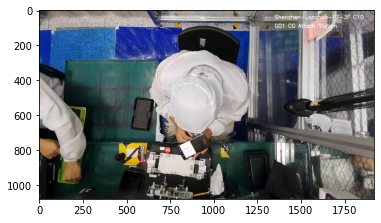

1223
check video and frames complete
oriD={}
newD={'video_20220810080429.mp4': 0, 'video_20220810080929.mp4': 0, 'video_20220810081429.mp4': 0, 'video_20220810081929.mp4': 0, 'video_20220810082429.mp4': 0, 'video_20220810082929.mp4': 0, 'video_20220810083429.mp4': 0, 'video_20220810083930.mp4': 0, 'video_20220810084430.mp4': 0, 'video_20220810084930.mp4': 0}


In [5]:
videoPathL = sorted(glob.glob("/home/jovyan/data-vol-2/HAR/C10/20220810/*.mp4"))[:10]
obj = PreprocessPretext( videoPathL, "../_data/pretext_0810_10" )
#obj.getOverallInfo(rotateL=None)
#obj.clip()
obj.check()
obj.generate_csv()
obj.updateRecord()

In [5]:
videoPathL = sorted(glob.glob("/home/jovyan/data-vol-2/HAR/C10/20220810/*.mp4"))
obj = PreprocessPretext( videoPathL, "../_data/pretext_0810_all" )
obj.clip()
obj.check()
obj.generate_csv()
obj.updateRecord()

len(hasProcessedS)=10
len(needProcessedS)=120
0, video_20220810085430.mp4, frames=8928, fps=30, height=1080, width=1920
1, video_20220810085930.mp4, frames=8926, fps=30, height=1080, width=1920
2, video_20220810090430.mp4, frames=8938, fps=30, height=1080, width=1920
3, video_20220810090930.mp4, frames=8926, fps=30, height=1080, width=1920
4, video_20220810091430.mp4, frames=8932, fps=30, height=1080, width=1920
5, video_20220810091930.mp4, frames=8910, fps=30, height=1080, width=1920
6, video_20220810092430.mp4, frames=8930, fps=30, height=1080, width=1920
7, video_20220810092930.mp4, frames=8929, fps=30, height=1080, width=1920
8, video_20220810093430.mp4, frames=8935, fps=30, height=1080, width=1920
9, video_20220810093930.mp4, frames=8914, fps=30, height=1080, width=1920
10, video_20220810094430.mp4, frames=8942, fps=30, height=1080, width=1920
11, video_20220810094930.mp4, frames=8925, fps=30, height=1080, width=1920
12, video_20220810095430.mp4, frames=8911, fps=30, height=1080, 